# Gradient Boosting Machines (GBMs) with XGBoost Intution & Model Building.


![](https://i.imgur.com/6MYc56a.png)


# The following topics are covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

# Let's begin by Importing the required libraries.

In [ ]:
#restart the kernel after installation
!pip install numpy pandas-profiling matplotlib seaborn --quiet

In [ ]:
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 120)

# Problem Statement

This tutorial takes a practical and coding-focused approach. We'll learn gradient boosting by applying it to a real-world dataset from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

# Importing and Overviewing the Data

Make sure to [accept the competition rules](https://www.kaggle.com/c/rossmann-store-sales/rules) before executing the following cell.

Let's load the data into Pandas dataframes.

In [3]:
ross_df = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')
test_df = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv')
submission_df = pd.read_csv('/kaggle/input/rossmann-store-sales/sample_submission.csv')

In [4]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [5]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [6]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [7]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# Dataset Description

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

### Files:
* **train.csv** - historical data including Sales
* **test.csv** - historical data excluding Sales
* **sample_submission.csv** - a sample submission file in the correct format
* **store.csv** - supplemental information about the stores

### Data fields:
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* **Id** - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince**[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since**[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

Since the store dataset also contains ome inportant features that can be used for machine learning a good first thing is to merge the information from `store_df` into `train_df` and `test_df`.

In [8]:
merged_df = ross_df.merge(store_df, how='left', on='Store') #this is gonna be the merged training dataset
merged_test_df = test_df.merge(store_df, how='left', on='Store') #this is gonna be the merged testing dataset

In [9]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


### Let's View Some Stats

In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [11]:
merged_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


The describe function shows scientific notation ***because the numbers in your dataset are very large or very small, and it's easier to read them in scientific notation. For example, the maximum value in the "Sales" column is 4.1551e+04, which means 41551***. This is nothing to worry about, incase if the other cells gives the similar scitific notation then we can use;

`import pandas as pd`

`pd.options.display.float_format = '{:.2f}'.format`

This will format all float values with two decimal places, which should make the output easier to read. You can adjust the number of decimal places by changing the number in the format string.

This doesn't give much information about the data we have so lets do EDA and visually see the distribution of the data. Before that we can visualize the missing data.

# Missing Data

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<AxesSubplot: >

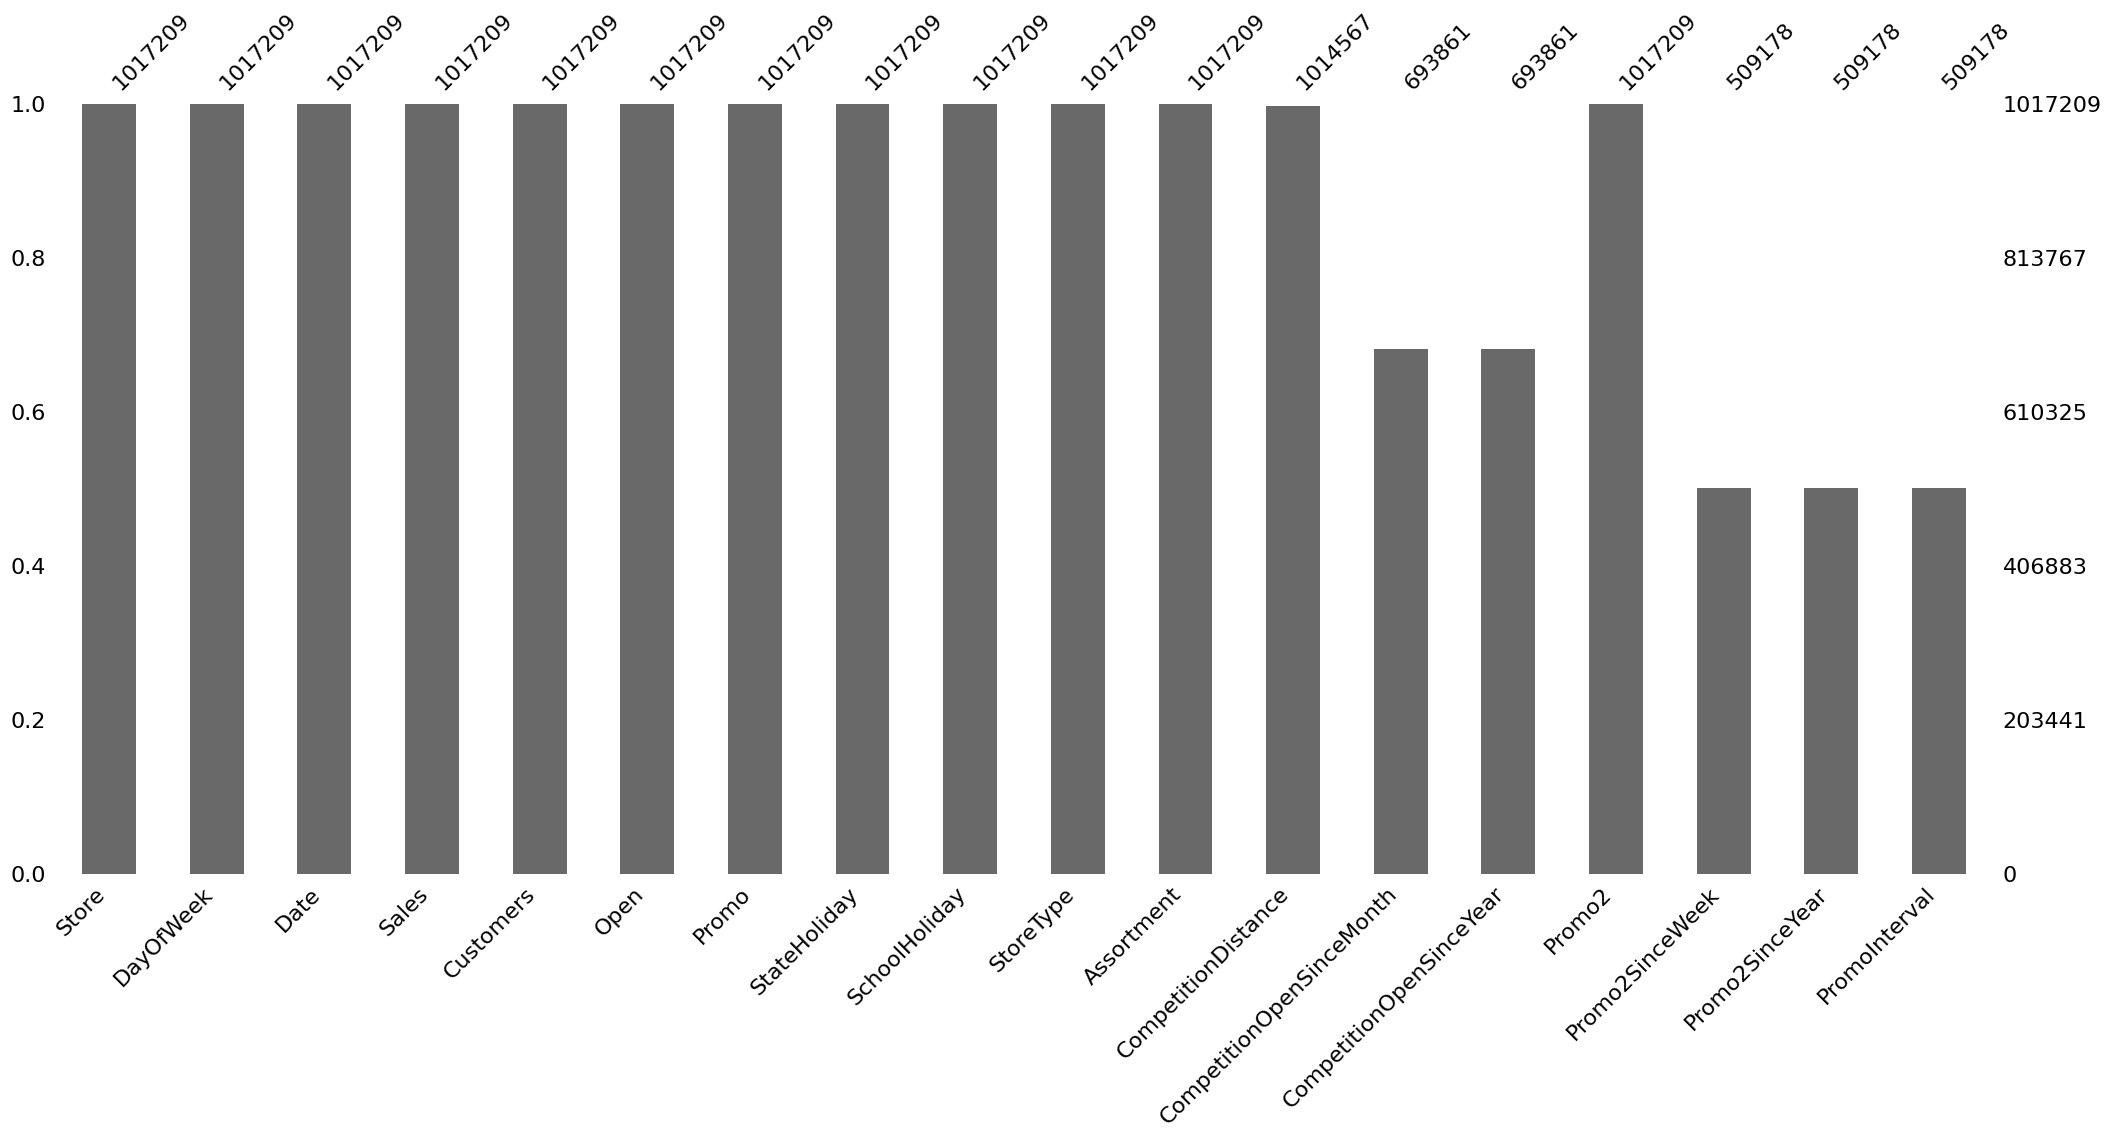

In [12]:
import missingno as msno

msno.bar(merged_df)

Many of the rows are quite filled. we also have some columns that needs to be imputed anyways. we can see that the info for $Promo2SinceWeek$, $Promo2SinceYear$, $PromoInterval$ have aprrox 50% of the value filled. This is a tricky one as we don't have much info to impute the rest. This needs to be seen that how imporant these columns are while predicting the $Sales$ so that we can decide wether to impute or remove these columns.

Let's move to Exploratory Data Analysis for more insights.

# Exploratotry Data Analysis

In [79]:
# This is just some asthetics settings for plots before we start EDA
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None) #Enable to show max columns in code cells
sns.set_style('darkgrid') #set sns plot background
matplotlib.rcParams['font.size'] = 14 #set the deafult plot font size for this notebook
matplotlib.rcParams['figure.figsize'] = (10, 6) #set the deafult plot size for this notebook
matplotlib.rcParams['figure.facecolor'] = '#00000000' #set matplotlib plot background

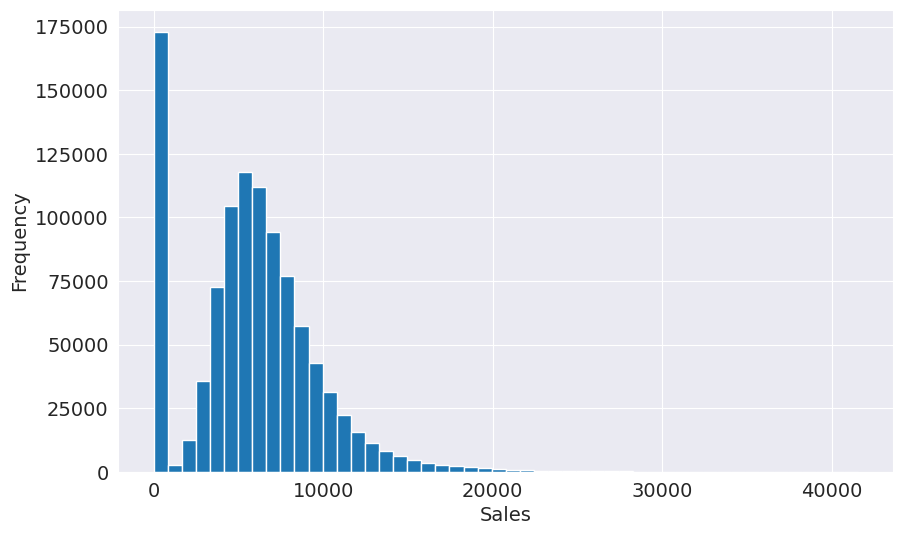

In [13]:
# Plot a histogram of the Sales column
plt.hist(merged_df['Sales'], bins=50)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

We can see that this is a "***Power Law Distribution***" which in statistics means  a phenomenon where a small number of items is clustered at the top of a distribution (or at the bottom), taking up 95% of the resources. In other words, it implies a small amount of occurrences is common, while larger occurrences are rare.

Also we can see that the `0` values is very $high$. This means that we have quite a number of _**zero sales**_ in the data. This could be account of many things which we can understand with futher analysis.

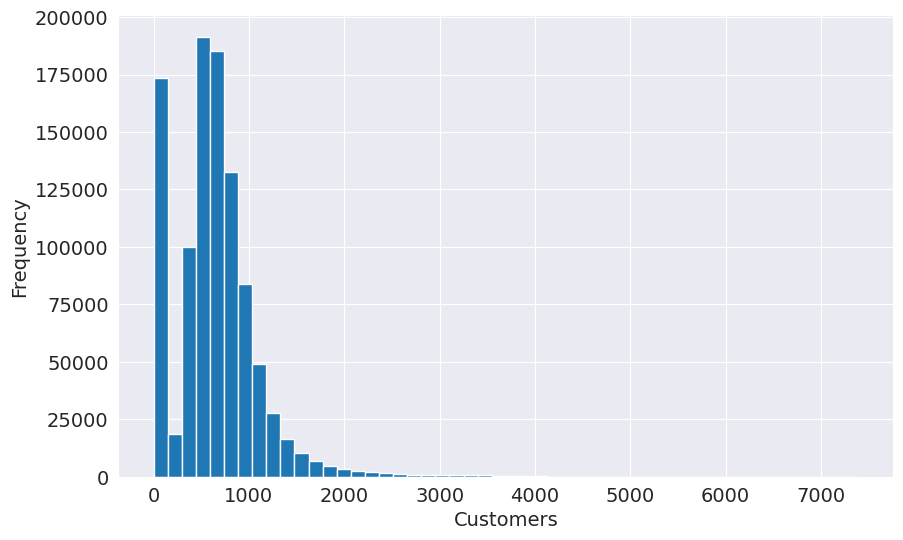

In [14]:
# Plot a histogram of the Customers column
plt.hist(merged_df['Customers'], bins=50)
plt.xlabel('Customers')
plt.ylabel('Frequency')
plt.show()

Again we can see a similar distribution with again high concentraion of _**zero customers**_. This can be a reson of `0 sales` but what's the reason for no customers? There could be multiple reasons why some of them as follows:
* **A holiday (Sunday holiday, state/school holiday)**
* **Store closed**

we can confirm using plots below.

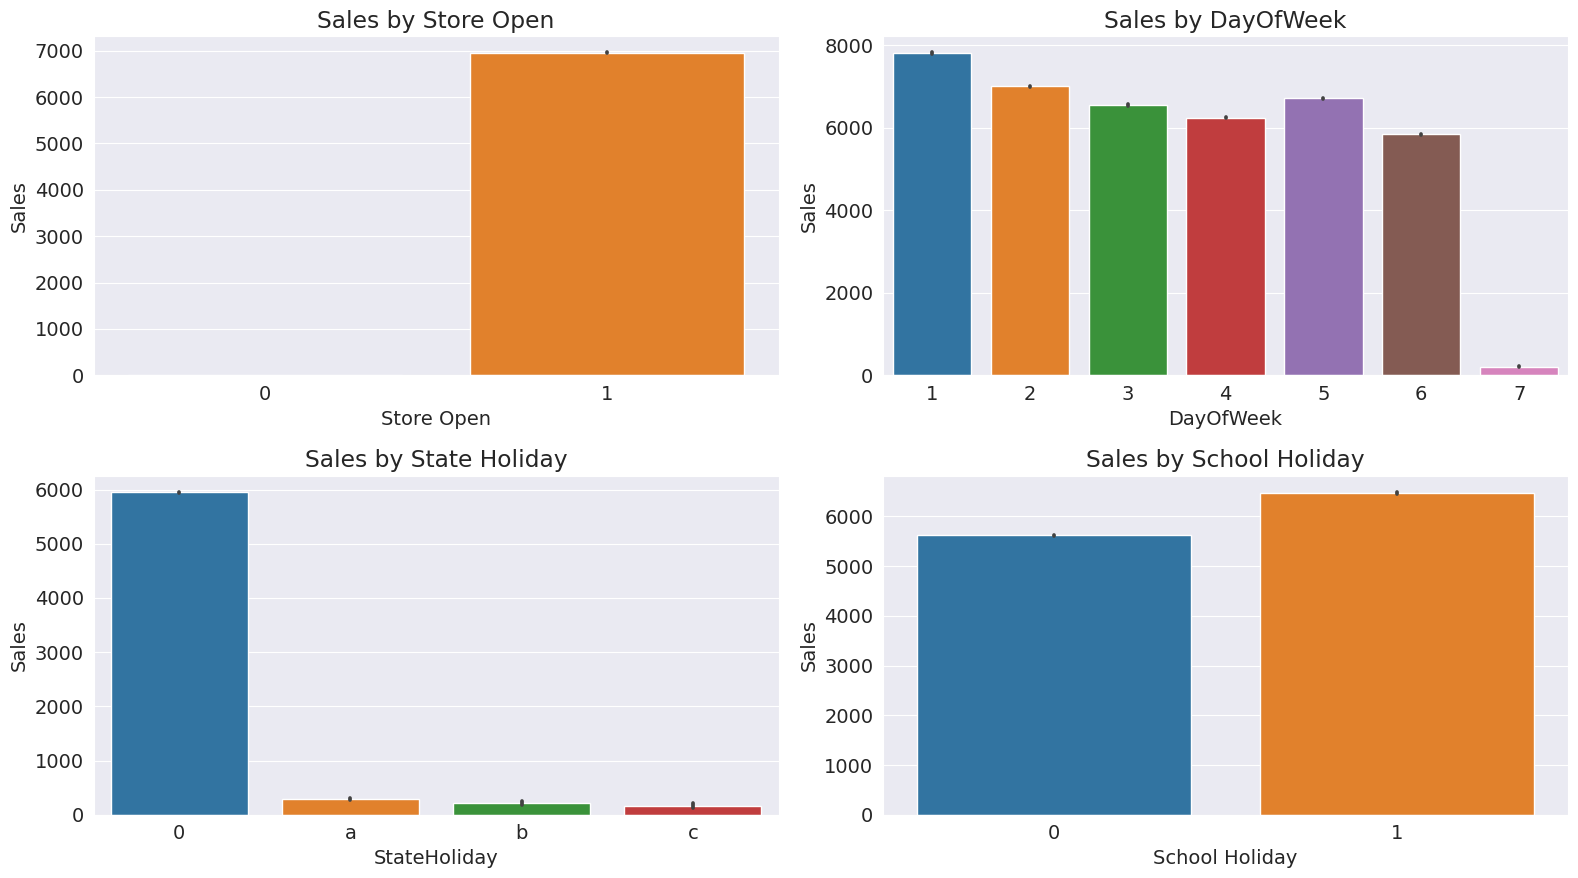

In [15]:
# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))

# Bar plot of Sales by Store Open
sns.barplot(data=merged_df, x="Open", y="Sales", ax=axes[0, 0])
axes[0, 0].set_title("Sales by Store Open")
axes[0, 0].set_xlabel("Store Open")
axes[0, 0].set_ylabel("Sales")

# Bar plot of Sales by DayOfWeek
sns.barplot(data=merged_df, x="DayOfWeek", y="Sales", ax=axes[0, 1])
axes[0, 1].set_title("Sales by DayOfWeek")
axes[0, 1].set_xlabel("DayOfWeek")
axes[0, 1].set_ylabel("Sales")

# Bar plot of Sales by StateHoliday
sns.barplot(data=merged_df, x="StateHoliday", y="Sales", ax=axes[1, 0])
axes[1, 0].set_title("Sales by State Holiday")
axes[1, 0].set_xlabel("StateHoliday")
axes[1, 0].set_ylabel("Sales")

# Bar plot of Sales by SchoolHoliday
sns.barplot(data=merged_df, x="SchoolHoliday", y="Sales", ax=axes[1, 1])
axes[1, 1].set_title("Sales by School Holiday")
axes[1, 1].set_xlabel("School Holiday")
axes[1, 1].set_ylabel("Sales")

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [29]:
# The above plots or codes seems to be overwhelming you can use the below to get a grouby.
list_a = ['Open','StateHoliday','SchoolHoliday','DayOfWeek']

for i in list_a:
    a=0
    merged_df
    a=merged_df.groupby(by=i)["Sales"].sum()
    print(a);

Open
0             0
1    5873180623
Name: Sales, dtype: int64
StateHoliday
0    5865164768
a       5890305
b       1433744
c        691806
Name: Sales, dtype: int64
SchoolHoliday
0    4696260531
1    1176920092
Name: Sales, dtype: int64
DayOfWeek
1    1130203012
2    1020411930
3     954962863
4     911177709
5     980555941
6     846317735
7      29551433
Name: Sales, dtype: int64


In these combined plot and groupby shows the `Sales` value on the conditions we discussed above. As we suspected there are quite come circumstances where the `Sales` is ***zero***.  The `Sale Value` is ***0*** or ***less*** when:

* When the store is closed (Obviously)
* When the day is '7' which is sunday. Although we can see some sales idk why.
* When the State Holdiday is either 'a', 'b' or 'c'. From the above description we can see that ***a = public holiday, b = Easter holiday, c = Christmas***

**We can also see that the `School Holiday` doesn't affect the sales. This info is very important as we can surely say that the $Sales$ is 0 when the store is closed. This is really helpull cause we can Hardcode this into the final submission without making our model predict that when the store is closed the $Sales$ is zero. This way we can reduce the error significantly and increase our accuracy of the final submission.**

Let's continue with our EDA

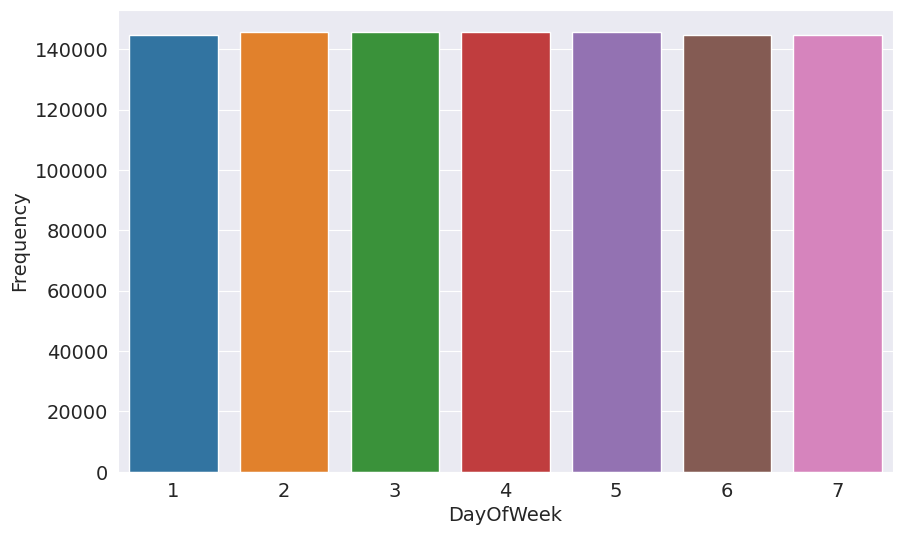

In [30]:
# Plot a bar plot of the DayOfWeek column
sns.countplot(x='DayOfWeek', data=merged_df)
plt.xlabel('DayOfWeek')
plt.ylabel('Frequency')
plt.show()

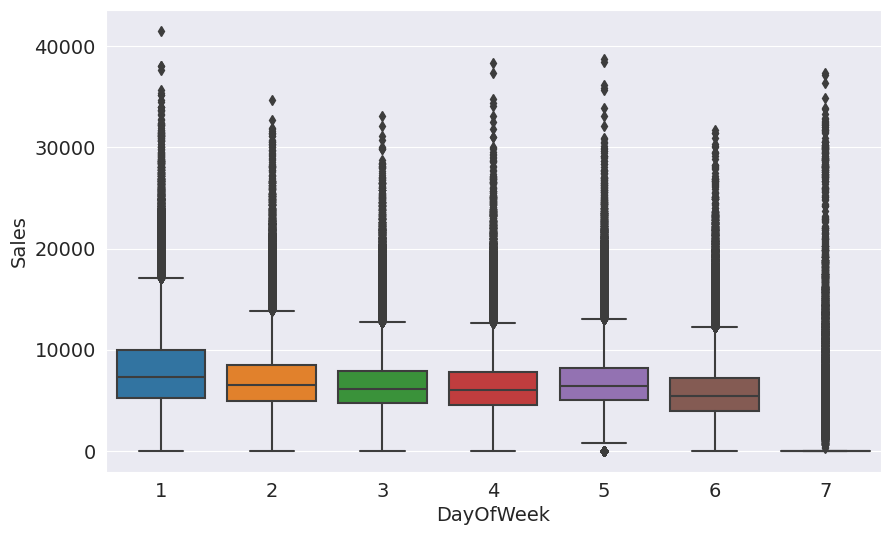

In [31]:
# Plot a box plot of the Sales column by DayOfWeek
sns.boxplot(x='DayOfWeek', y='Sales', data=merged_df)
plt.xlabel('DayOfWeek')
plt.ylabel('Sales')
plt.show()

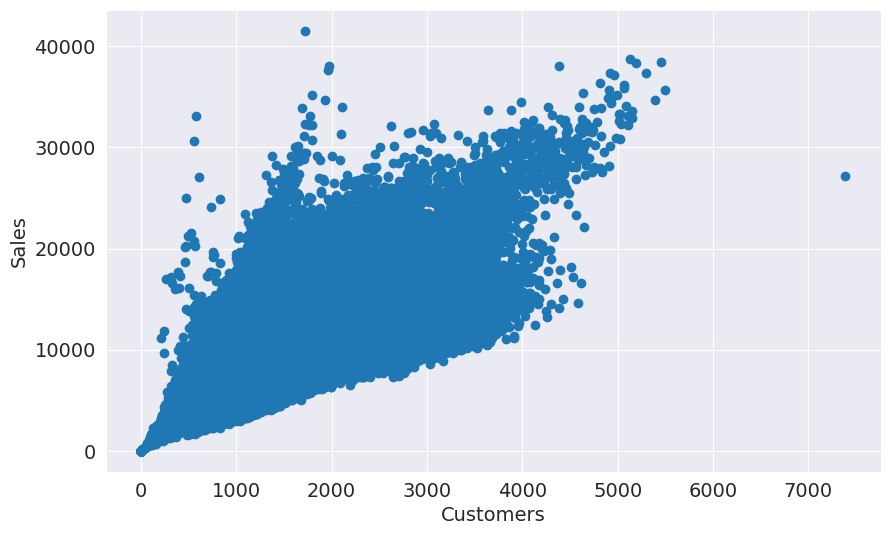

In [32]:
# Plot a scatter plot of the Sales column by Customers
plt.scatter(x='Customers', y='Sales', data=merged_df)
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

Here we can see the relationship with $Sales$ and $Customers$ is linear with some outliers. This is expected as more no. of customers is directly propotional to more sales.

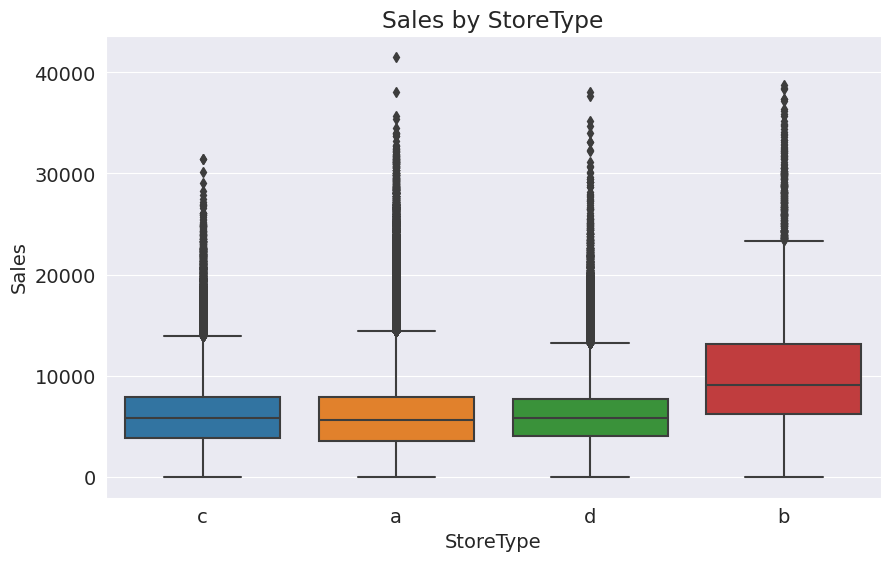

In [33]:
# Box plot of Sales by StoreType
sns.boxplot(data=merged_df, x="StoreType", y="Sales")
plt.title("Sales by StoreType")
plt.xlabel("StoreType")
plt.ylabel("Sales")
plt.show()

For some reason the sales with the $Storetype$ **b** is relatively high compared to other stores. The description of these attributes is not given in the data but to some extent we can say that the $Sales Numbers$ will be high fot **b** type store as compared to other $Storetypes$

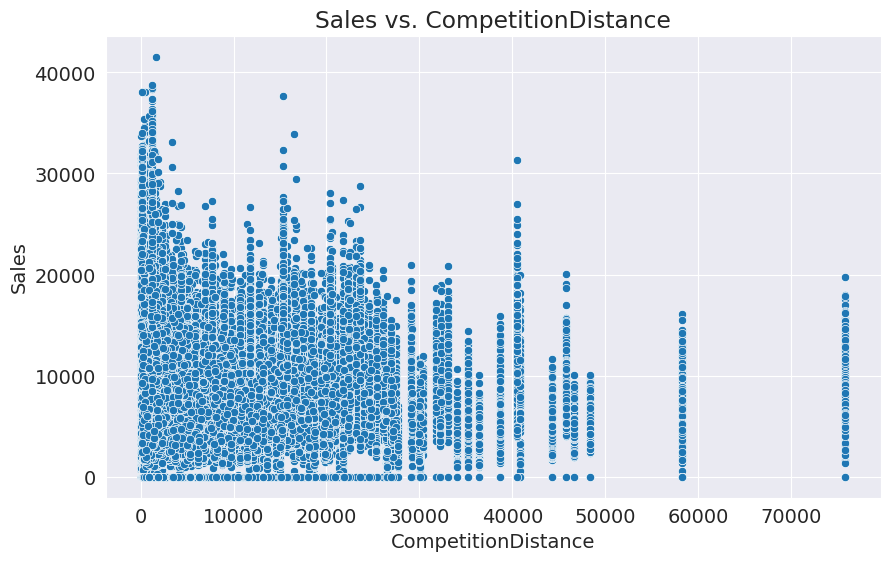

In [34]:
# Scatter plot of CompetitionDistance and Sales
sns.scatterplot(data=merged_df, x="CompetitionDistance", y="Sales")
plt.title("Sales vs. CompetitionDistance")
plt.xlabel("CompetitionDistance")
plt.ylabel("Sales")
plt.show()

As we can see the graph there seems to be no relative relationship between the $Competition Distance$ and $Sales$ as the sales seems high even when the competition is next door.

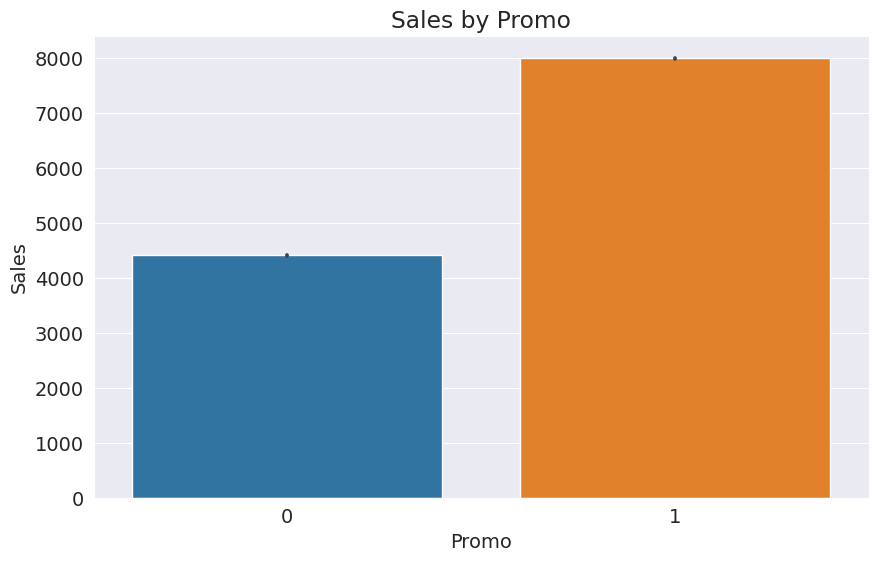

In [39]:
# Bar plot of Sales by Promo
sns.barplot(data=merged_df, x="Promo", y="Sales")
plt.title("Sales by Promo")
plt.xlabel("Promo")
plt.ylabel("Sales")
plt.show()

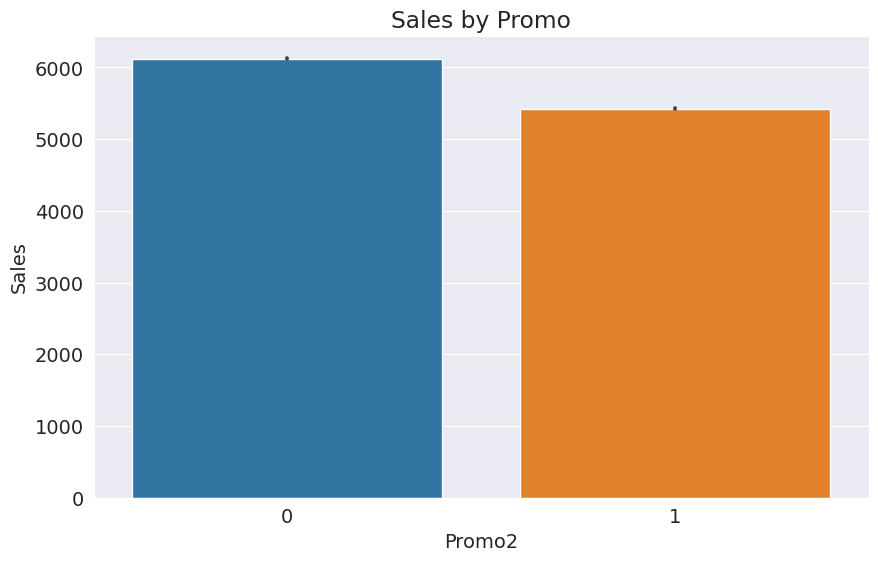

In [40]:
# Bar plot of Sales by Promo2
sns.barplot(data=merged_df, x="Promo2", y="Sales")
plt.title("Sales by Promo")
plt.xlabel("Promo2")
plt.ylabel("Sales")
plt.show()

This is quite intresting that when $Promo$ (**whether a store is running a promo on that day**) is happening then the store sales went up. This is usual as seen with our nearby stores as well. But when $promo2$ (**is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating**) is happening the store sales actually when down. This is unusual and there could be something going on with pricing which affected the sales it seems. we also wanna look at the no. of customers that came in Or all these could be due to the missing data too. So, let's verify that.

In [50]:
merged_df.groupby(by='Promo2')['Sales','Customers'].sum()

/tmp/ipykernel_34/1215658224.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_df.groupby(by='Promo2')['Sales','Customers'].sum()


,Sales,Customers
Promo2,,
0,3111542628,357125490
1,2761637995,286916265


well, Seems like the sales is lower due to less customers but why less customers? for that we don't have enough data to fetch insights. **All we know now is that the $Promo2$ ins't succesful in increasing the sales.**

/tmp/ipykernel_34/2668953032.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df.corr(), cmap='coolwarm')


<AxesSubplot: >

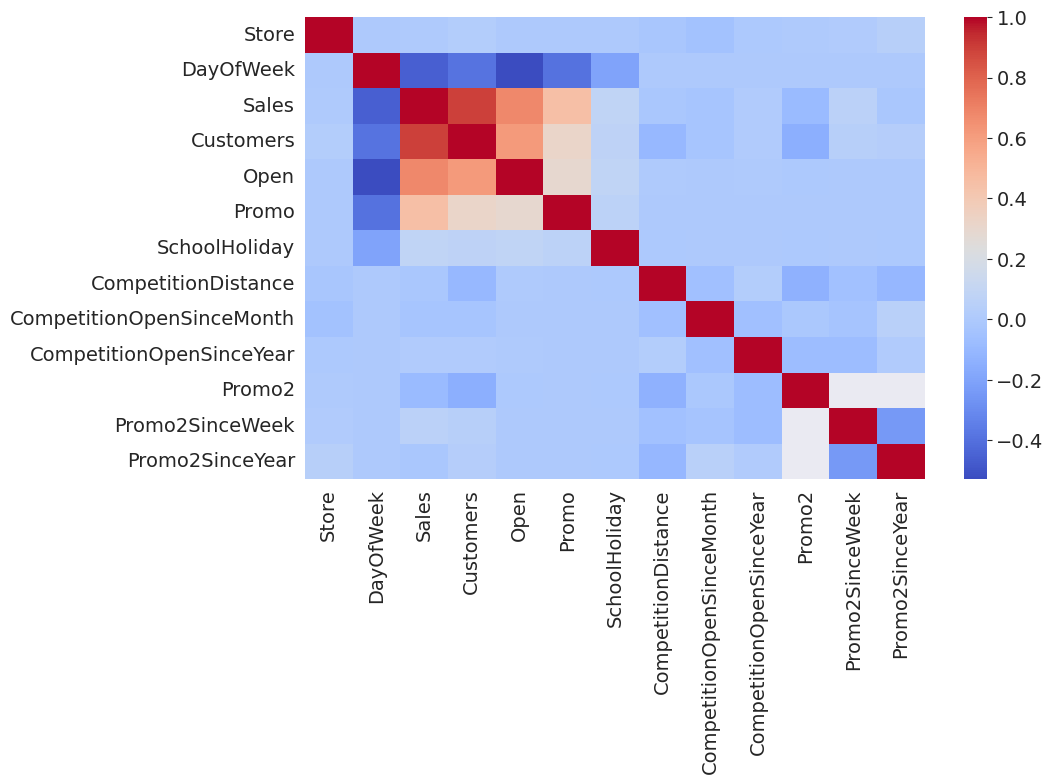

In [51]:
#let's end the EDA with an Coorelations Heatmap
sns.heatmap(merged_df.corr(), cmap='coolwarm')

There seems not much correlation going with the values each other. This might severly affect our model. Thus a $Feature Engineering$ would be necessary to create new relevant features or modify existing features to make them more relevant.

# Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

$Feature engineering$ is the process of transforming raw data into features that can be used by a machine learning model to make accurate predictions. It involves selecting, extracting, and transforming the most relevant information from the raw data to create a new set of features that captures the underlying patterns and relationships in the data.

Feature engineering is important because it can significantly improve the performance of a machine learning model. By creating new features that capture the most important aspects of the data, we can help the model identify the underlying patterns and relationships in the data more accurately. This, in turn, leads to better predictions and more reliable insights.

In [52]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

### Date

**First, let's convert `Date` to a `datetime` column and extract different parts of the date. This will be very usefull case a ML model there is no use n having a `Date` in $object$ format. Thus extracting them into $year$, $month$, $day$, $week of the year$ and $day of the week$ will be very helpful for the model to understand any seasonality between these features and the rest of the columns.**

In [14]:
def split_date(df): #A helper function that takes a df and finds the Date column and extract the necessary info.
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week  #since we have day of the week already let's extrac the rest

In [15]:
split_date(merged_df)
split_date(merged_test_df)

In [16]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


### Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [59]:
merged_df.groupby(by='Open')['Sales'].sum()

Open
0             0
1    5873180623
Name: Sales, dtype: int64

**As dicussed earlier Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row. Later we'll mark zero for sales whereever the store is closed**

In [17]:
merged_df = merged_df[merged_df.Open == 1].copy() #Filtering only the rows where the store is open.

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store. As having the values split into year and months we'll try having the total no. of time in months and see if it helps our model.

In [18]:
"""
This code creates a new feature called 'CompetitionOpen' in the input DataFrame, 
which represents the number of months that the competition for a given store has been open.

The function takes as input a DataFrame with columns 'Year', 'Month', 'CompetitionOpenSinceYear', and 'CompetitionOpenSinceMonth'. 
It first calculates the difference in months between the current year/month and the year/month when the competition opened. 
If the difference is negative (i.e., the competition has not yet opened), the function sets the value of 'CompetitionOpen' to 0.
Finally, it fills any missing values in 'CompetitionOpen' with 0.
"""    

def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [19]:
comp_months(merged_df)
comp_months(merged_test_df)

Let's view the results of the new columns we've created.

In [20]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
1015902,2013-01-02,280.0,2008.0,9.0,52.0
367969,2014-08-13,110.0,NaN,NaN,0.0
355484,2014-08-26,4520.0,NaN,NaN,0.0
343719,2014-09-08,3290.0,2007.0,1.0,92.0
106628,2015-04-27,1910.0,2009.0,4.0,72.0
645296,2013-11-30,1610.0,NaN,NaN,0.0
655803,2013-11-21,600.0,1999.0,11.0,168.0
139666,2015-03-28,1100.0,2009.0,6.0,69.0
787340,2013-07-26,580.0,2008.0,2.0,65.0
150263,2015-03-19,4770.0,NaN,NaN,0.0


### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month. This is another try to check wether this tranformation is helpful for our model.

In [22]:
"""

`promo_cols()` function creates new features related to promotions. It calculates how long the promotional offer has been open (in months) and 
creates a new feature 'Promo2Open'. It also creates a new feature 'IsPromo2Month' to check whether a new round of promotions was started 
in the current month.

`check_promo_month(row)` is a helper function used by `promo_cols()` function to check whether a new round of promotions was started in the current month. 
It takes a row as an input and returns 1 if a new round of promotions was started in the current month, otherwise 0. 
It uses the 'PromoInterval' column to get the months when the promotions are active and checks whether the current month is in that list.

"""


def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [23]:
promo_cols(merged_df)
promo_cols(merged_test_df)

Let's view the results of the columns we've created.

In [24]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
223617,2015-01-12,0,NaN,NaN,NaN,0.000000,0
436367,2014-06-05,0,NaN,NaN,NaN,0.000000,0
871740,2013-05-11,0,NaN,NaN,NaN,0.000000,0
983054,2013-01-31,1,2012.0,22.0,"Mar,Jun,Sept,Dec",8.098361,0
788435,2013-07-25,0,NaN,NaN,NaN,0.000000,0
325743,2014-09-27,0,NaN,NaN,NaN,0.000000,0
573098,2014-02-03,0,NaN,NaN,NaN,0.000000,0
321593,2014-10-01,1,2009.0,31.0,"Feb,May,Aug,Nov",62.065574,0
635196,2013-12-09,0,NaN,NaN,NaN,0.000000,0
230889,2015-01-05,0,NaN,NaN,NaN,0.000000,0


The features related to competition and promotion are now much more useful.

# Preparing Input and Target Columns

Let's select the columns that we'll use for training. Since we modified several columsn through feature engineering we have to either delete the old columns or filter the dataset wih only necessay and modified columns. The later method is what i'm gonna use also it is pretty handy. Refer [HERE](https://www.kaggle.com/code/sridharstreaks/decision-trees-intution-model-building?scriptVersionId=127577600&cellId=35).

Below i'm using a method by which:

1. ***I'll create a list of column names extracted from my source dataset like `list(dataset_name.columns)` . This will create a list of column names I wish to extract.***
2. ***Now i can store this list in some value like `name_of_list`. Then i can use this stored list of column names to act like a filter on any dataset that contains similar column names. This is actually usefull that you don't have to modify the dataframe each time.***

In [73]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [25]:
# Selecting only the required columns which i think will be good for ML model.

input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [28]:
# This created a dataframe with only columns names from the list we created above.

inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()
inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,5,1,0,1,c,a,1270.0,82.0,31,7,2015,31,0,0.000000,0
1,2,5,1,0,1,a,a,570.0,92.0,31,7,2015,31,1,64.131148,1
2,3,5,1,0,1,a,a,14130.0,103.0,31,7,2015,31,1,51.901639,1
3,4,5,1,0,1,c,c,620.0,70.0,31,7,2015,31,0,0.000000,0
4,5,5,1,0,1,a,a,29910.0,3.0,31,7,2015,31,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,0,a,1,b,a,150.0,76.0,1,1,2013,1,0,0.000000,0
1016827,733,2,0,a,1,b,b,860.0,159.0,1,1,2013,1,0,0.000000,0
1016863,769,2,0,a,1,b,b,840.0,0.0,1,1,2013,1,1,1.213115,1
1017042,948,2,0,a,1,b,b,1430.0,0.0,1,1,2013,1,0,0.000000,0


In [29]:
# Similarly doing the same for the test dataset
test_inputs = merged_test_df[input_cols].copy()
test_inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,4,1,0,0,c,a,1270.0,84.0,17,9,2015,38,0,0.000000,0
1,3,4,1,0,0,a,a,14130.0,105.0,17,9,2015,38,1,53.508197,0
2,7,4,1,0,0,a,c,24000.0,29.0,17,9,2015,38,0,0.000000,0
3,8,4,1,0,0,a,a,7520.0,11.0,17,9,2015,38,0,0.000000,0
4,9,4,1,0,0,a,c,2030.0,181.0,17,9,2015,38,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,0,0,0,a,a,1900.0,14.0,1,8,2015,31,1,24.000000,0
41084,1112,6,0,0,0,c,c,1880.0,112.0,1,8,2015,31,0,0.000000,0
41085,1113,6,0,0,0,a,c,9260.0,0.0,1,8,2015,31,0,0.000000,0
41086,1114,6,0,0,0,a,c,870.0,0.0,1,8,2015,31,0,0.000000,0


Let's also identify numeric and categorical columns. We can use a automatically select numerical columns using `dtypes` like [THIS](https://www.kaggle.com/code/sridharstreaks/decision-trees-intution-model-building?scriptVersionId=127577600&cellId=41) else we can choose manually like below. 

## **Note that we can treat binary categorical columns (0/1) as numeric columns.**

**As of now there is no major difference in treating the columns like `SchoolHoliday` , `Promo` etc as numerical even those they are categorical solumn with numbers. If the perfomance of the model gets affected then we can try treating these as categorical columns**

In [30]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

# Impute missing numerical data

Imputing missing data is the process of filling in missing values in a dataset with estimated values. Missing data can arise due to a variety of reasons such as data entry errors, sensor malfunction, or simply the lack of information. Missing data can be problematic as it can lead to biased or inefficient analysis, and sometimes make the data unusable altogether.

There are several methods for imputing missing data, including mean imputation, mode imputation, regression imputation, and multiple imputation. Mean imputation involves replacing missing values with the mean value of the non-missing values for that variable. Mode imputation is similar, but replaces missing values with the most common value for that variable. Regression imputation involves using a regression model to predict the missing values based on other variables in the dataset. Multiple imputation involves creating multiple imputed datasets and combining the results to create a final dataset.

The choice of imputation method depends on the nature of the missing data and the goals of the analysis. Regardless of the method used, it is important to carefully consider the potential impact of imputing missing data on the results of the analysis and to report any imputation methods used in the final analysis.

let's first check the amount of missing data in out `train` and `test` dataset

In [80]:
inputs[numeric_cols]

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear
0,1,1,1,1270.0,82.0,0,0.000000,0,31,7,2015,31
1,2,1,1,570.0,92.0,1,64.131148,1,31,7,2015,31
2,3,1,1,14130.0,103.0,1,51.901639,1,31,7,2015,31
3,4,1,1,620.0,70.0,0,0.000000,0,31,7,2015,31
4,5,1,1,29910.0,3.0,0,0.000000,0,31,7,2015,31
...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,0,1,150.0,76.0,0,0.000000,0,1,1,2013,1
1016827,733,0,1,860.0,159.0,0,0.000000,0,1,1,2013,1
1016863,769,0,1,840.0,0.0,1,1.213115,1,1,1,2013,1
1017042,948,0,1,1430.0,0.0,0,0.000000,0,1,1,2013,1


In [78]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [79]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

***Seems like competition distance is the only missing value, and we can simply fill it with the 2Xhighest value (to indicate that competition is very far away). This is only a assumption of mine you are welcome to use any `imputing methods` or delete those rows.But we can't delete the rows here as the summision csv requires all the rows from the `test` set. so, the next best idea is to make them negligible to have very less or no impact on our model.***

In [33]:
max_distance = inputs.CompetitionDistance.max()
max_distance

75860.0

In [38]:
inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True) #Filling with 2X Highest value to indicate that the competition is non existent
test_inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)

In [39]:
inputs[numeric_cols].isna().sum()

Store                  0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionOpen        0
Promo2                 0
Promo2Open             0
IsPromo2Month          0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
dtype: int64

In [40]:
test_inputs[numeric_cols].isna().sum()

Store                  0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionOpen        0
Promo2                 0
Promo2Open             0
IsPromo2Month          0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
dtype: int64

# Scale Numeric Values

In machine learning, scaling numerical features is the process of transforming numerical data so that it falls within a specific range. This is important because it can help improve the performance of certain machine learning algorithms. Some of the most commonly used scaling techniques are min-max scaling, mean normalization, and standardization.

Scaling numerical features is important because many machine learning algorithms work better when the features are on a similar scale. This is because algorithms like linear regression and K-nearest neighbors use distance measures to compare features, and when the features are on vastly different scales, this can cause problems. Additionally, scaling can help to speed up the convergence of some optimization algorithms used in machine learning.

Another reason why scaling numerical features is important is that some features may have very different variances or ranges, which can cause them to dominate the objective function of the machine learning algorithm. This can lead to biased results, where certain features have a much larger influence on the outcome than others. By scaling the features, we can avoid this problem.

There are several methods by which we can scale the numerical features and it also depends on various factors like type of data we have, do we have outliers, do we wanna scale including negative scales etc. I'll link a article to know more about which scaler to use when [HERE](https://towardsdatascience.com/feature-scaling-effect-of-different-scikit-learn-scalers-deep-dive-8dec775d4946).

Here i'm gonna use `StandardScaler` which is quite reliable in many situations. You can view my other methods [Quantiletransformer](https://www.kaggle.com/code/sridharstreaks/decision-trees-intution-model-building?scriptVersionId=127577600&cellId=53). Before that we can view how our data is distributed before scaling using the describe function.

In [51]:
inputs[numeric_cols].describe().loc[['min','max']]

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear
min,1.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,1.0,1.0,2013.0,1.0
max,1115.0,1.0,1.0,151720.0,1386.0,1.0,72.0,1.0,31.0,12.0,2015.0,52.0


In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(inputs[numeric_cols])

In [52]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [53]:
inputs[numeric_cols].describe().loc[['min','max']]

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear
min,-1.732571,-0.897887,-0.489947,-0.539902,-0.643561,-0.997372,-0.686969,-0.418274,-1.708501,-1.457834,-1.070346,-1.573812
max,1.729942,1.113726,2.041038,13.540960,20.617466,1.002635,3.105031,2.390776,1.746347,1.851502,1.502796,1.970371


This is after we scale the data. As we can see the data is nicely scalled between the range $(-1,1)$ according to each feature weightage. First we'll use this scaler's scaled values into our model. Then if this isn't satisfactory then we'll try to incoporate other scalers.

# Encode Categorical Columns

In machine learning, encoding categorical features refers to the process of transforming non-numerical data into numerical data. This is important because most machine learning algorithms are designed to work with numerical data, and as such, non-numerical data needs to be transformed before it can be used to train these models.

Categorical variables are variables that represent categories or groups, such as gender (male/female), education level (high school/bachelor's degree/master's degree), or geographic region (North/South/East/West). There are different ways to encode categorical variables, including one-hot encoding, label encoding, and binary encoding.

One-hot encoding involves creating a new binary column for each unique category in a categorical variable. Label encoding involves assigning a unique integer to each unique category in a categorical variable. Binary encoding is similar to one-hot encoding, but instead of creating a new column for each unique category, it creates a new column for each bit in the binary representation of the unique integer assigned to each category.

The choice of encoding method depends on the type of data and the specific machine learning algorithm being used. The importance of encoding categorical features lies in the fact that they can be a valuable source of information in a dataset, but need to be transformed into numerical data for machine learning algorithms to be able to use them effectively. By encoding categorical features, we can capture the information they contain and improve the accuracy of our machine learning models.

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [54]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols]) #This will handle missing/NaN values while Encoding values

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [56]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
encoded_cols

['DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c']

In [57]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols]) #merging the encoded columns onto out inputs dataset
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [58]:
#Since i was using a list of columns instead of modifying the actual data i can simply combine the ist to create new ones and use as a new filter list.

X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

X

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,-1.732571,1.113726,2.041038,-0.423877,0.614306,-0.997372,-0.686969,-0.418274,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-1.729462,1.113726,2.041038,-0.488851,0.767705,1.002635,2.690605,2.390776,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.726354,1.113726,2.041038,0.769794,0.936443,1.002635,2.046518,2.390776,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.723246,1.113726,2.041038,-0.484210,0.430228,-0.997372,-0.686969,-0.418274,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.720138,1.113726,2.041038,2.234501,-0.597541,-0.997372,-0.686969,-0.418274,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,0.384100,-0.897887,2.041038,-0.527835,0.522267,-0.997372,-0.686969,-0.418274,-1.708501,-1.457834,-1.070346,-1.573812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1016827,0.542617,-0.897887,2.041038,-0.461933,1.795475,-0.997372,-0.686969,-0.418274,-1.708501,-1.457834,-1.070346,-1.573812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1016863,0.654511,-0.897887,2.041038,-0.463789,-0.643561,1.002635,-0.623078,2.390776,-1.708501,-1.457834,-1.070346,-1.573812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1017042,1.210876,-0.897887,2.041038,-0.409025,-0.643561,-0.997372,-0.686969,-0.418274,-1.708501,-1.457834,-1.070346,-1.573812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### We haven't created a validation set yet, because we'll use ***K-fold*** cross validation.

Validation set is important to test our model's accuracy since we do not have a `test_targets` or otherwise called as `y_test` dataset it is good to create a validaton dataset.

**While working with chronological data, it's often a good idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.**

Since for the Demonstration purpose we'll ignore that rule and use **K-fold Corss Validation**

# Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 

Gradient boosting is a popular machine learning algorithm used for both regression and classification tasks. It is an ensemble method that combines the predictions of several weak decision trees to form a more accurate prediction. Gradient boosting works by fitting the weak decision trees on the residuals of the previous decision trees. This way, the model learns to correct the errors of the previous model and makes more accurate predictions.

Some advantages of gradient boosting are:

1. High accuracy: Gradient boosting is known for its high accuracy in predicting outcomes, making it an ideal choice for many machine learning problems.

2. Robustness to outliers: Gradient boosting is less sensitive to outliers as it uses decision trees which can handle missing and inconsistent data.

3. Feature importance: Gradient boosting can be used to identify the most important features in a dataset, which is useful for feature selection and reducing dimensionality.

4. Flexibility: Gradient boosting can be used for both regression and classification problems, and can handle different types of data such as numerical, categorical, and text data.

5. Scalability: Gradient boosting can be easily parallelized and scaled up to handle large datasets.

6. Regularization: Gradient boosting includes regularization techniques such as early stopping and shrinkage, which help prevent overfitting and improve model performance.

For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)



### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library. Also the parameters are similar to that of the random forests and decision trees. you can look at them [HERE](https://www.kaggle.com/code/sridharstreaks/decision-trees-intution-model-building?scriptVersionId=127577600&cellId=70) and [HERE](https://www.kaggle.com/code/sridharstreaks/random-forests-intuition-model-building?scriptVersionId=128019113&cellId=71). 

In [63]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4) #for demonstration i'be using very less estimators

Let's train the model using `model.fit`.

In [64]:
from tqdm import tqdm #importing tqdm to seeing the loading bar

for i in tqdm(range(100)):
    model.fit(X, targets)

100%|██████████| 100/100 [17:53<00:00, 10.73s/it]


This demo ML model took almost `20mins` as we can see. This is due to the numerous decision trees created to reduce the `error/loss`.

XGBoost (Extreme Gradient Boosting) is a type of gradient boosting machine that builds an ensemble of decision trees, while Random Forest (RF) is an ensemble of decision trees that are built independently.

In RF, each decision tree is built independently by randomly selecting a subset of features and training the tree on a bootstrapped sample of the dataset. The final prediction is then obtained by averaging the predictions of all the trees in the ensemble.

In contrast, XGBoost builds decision trees sequentially, where each new tree tries to correct the mistakes of the previous trees. The algorithm starts with a single decision tree, and in each subsequent iteration, it adds a new tree to the ensemble that tries to minimize the residual errors of the previous trees. The final prediction is obtained by summing the predictions of all the trees in the ensemble.

XGBoost has several advantages over RF and decision trees:

1. Regularization: XGBoost has built-in regularization techniques such as L1 and L2 regularization to prevent overfitting.

2. Scalability: XGBoost is highly scalable and can handle large datasets with millions of examples and features.

3. Speed: XGBoost is optimized for speed and can train models faster than RF and other gradient boosting algorithms.

4. Performance: XGBoost has been shown to outperform other machine learning algorithms on a wide range of tasks, including regression, classification, and ranking.

# Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [65]:
preds = model.predict(X)

In [66]:
preds

array([ 8127.9404,  7606.919 ,  8525.857 , ...,  6412.8247,  9460.068 ,
       10302.145 ], dtype=float32)

# Evaluation

Let's evaluate the predictions using RMSE error.

The root mean squared error (RMSE) is a commonly used evaluation metric for regression models in machine learning. It is the square root of the average of the squared differences between the predicted and actual values of the target variable. In the context of XGBoost regression models, RMSE is used to measure the difference between the predicted and actual values of the target variable (i.e., the sales) in the Rossman Store Sales dataset.

The intuition behind using RMSE is to penalize the model more for larger errors, as the squared term amplifies larger differences between predicted and actual values. This means that RMSE is a more sensitive metric than other measures such as mean absolute error (MAE), which treats all errors as equally important.

XGBoost is different from random forest and decision trees because it uses gradient boosting, which is a technique that trains many weak learners (i.e., decision trees) in sequence to build a strong model. This allows XGBoost to be more powerful and flexible than random forests and decision trees, as it can learn complex, non-linear relationships in the data. Additionally, XGBoost includes regularization techniques to prevent overfitting and improve generalization performance, which can be a challenge for decision trees and random forests.

Read more about [HERE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [67]:
from sklearn.metrics import mean_squared_error

# just creating a helper function as we'll using this rmse to evaluate multiple models and paramaters futher down.
# Thus instead of writing this code again and again i'm creating this simple function.
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [68]:
rmse(preds, targets)

2377.752008804669

# Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [69]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

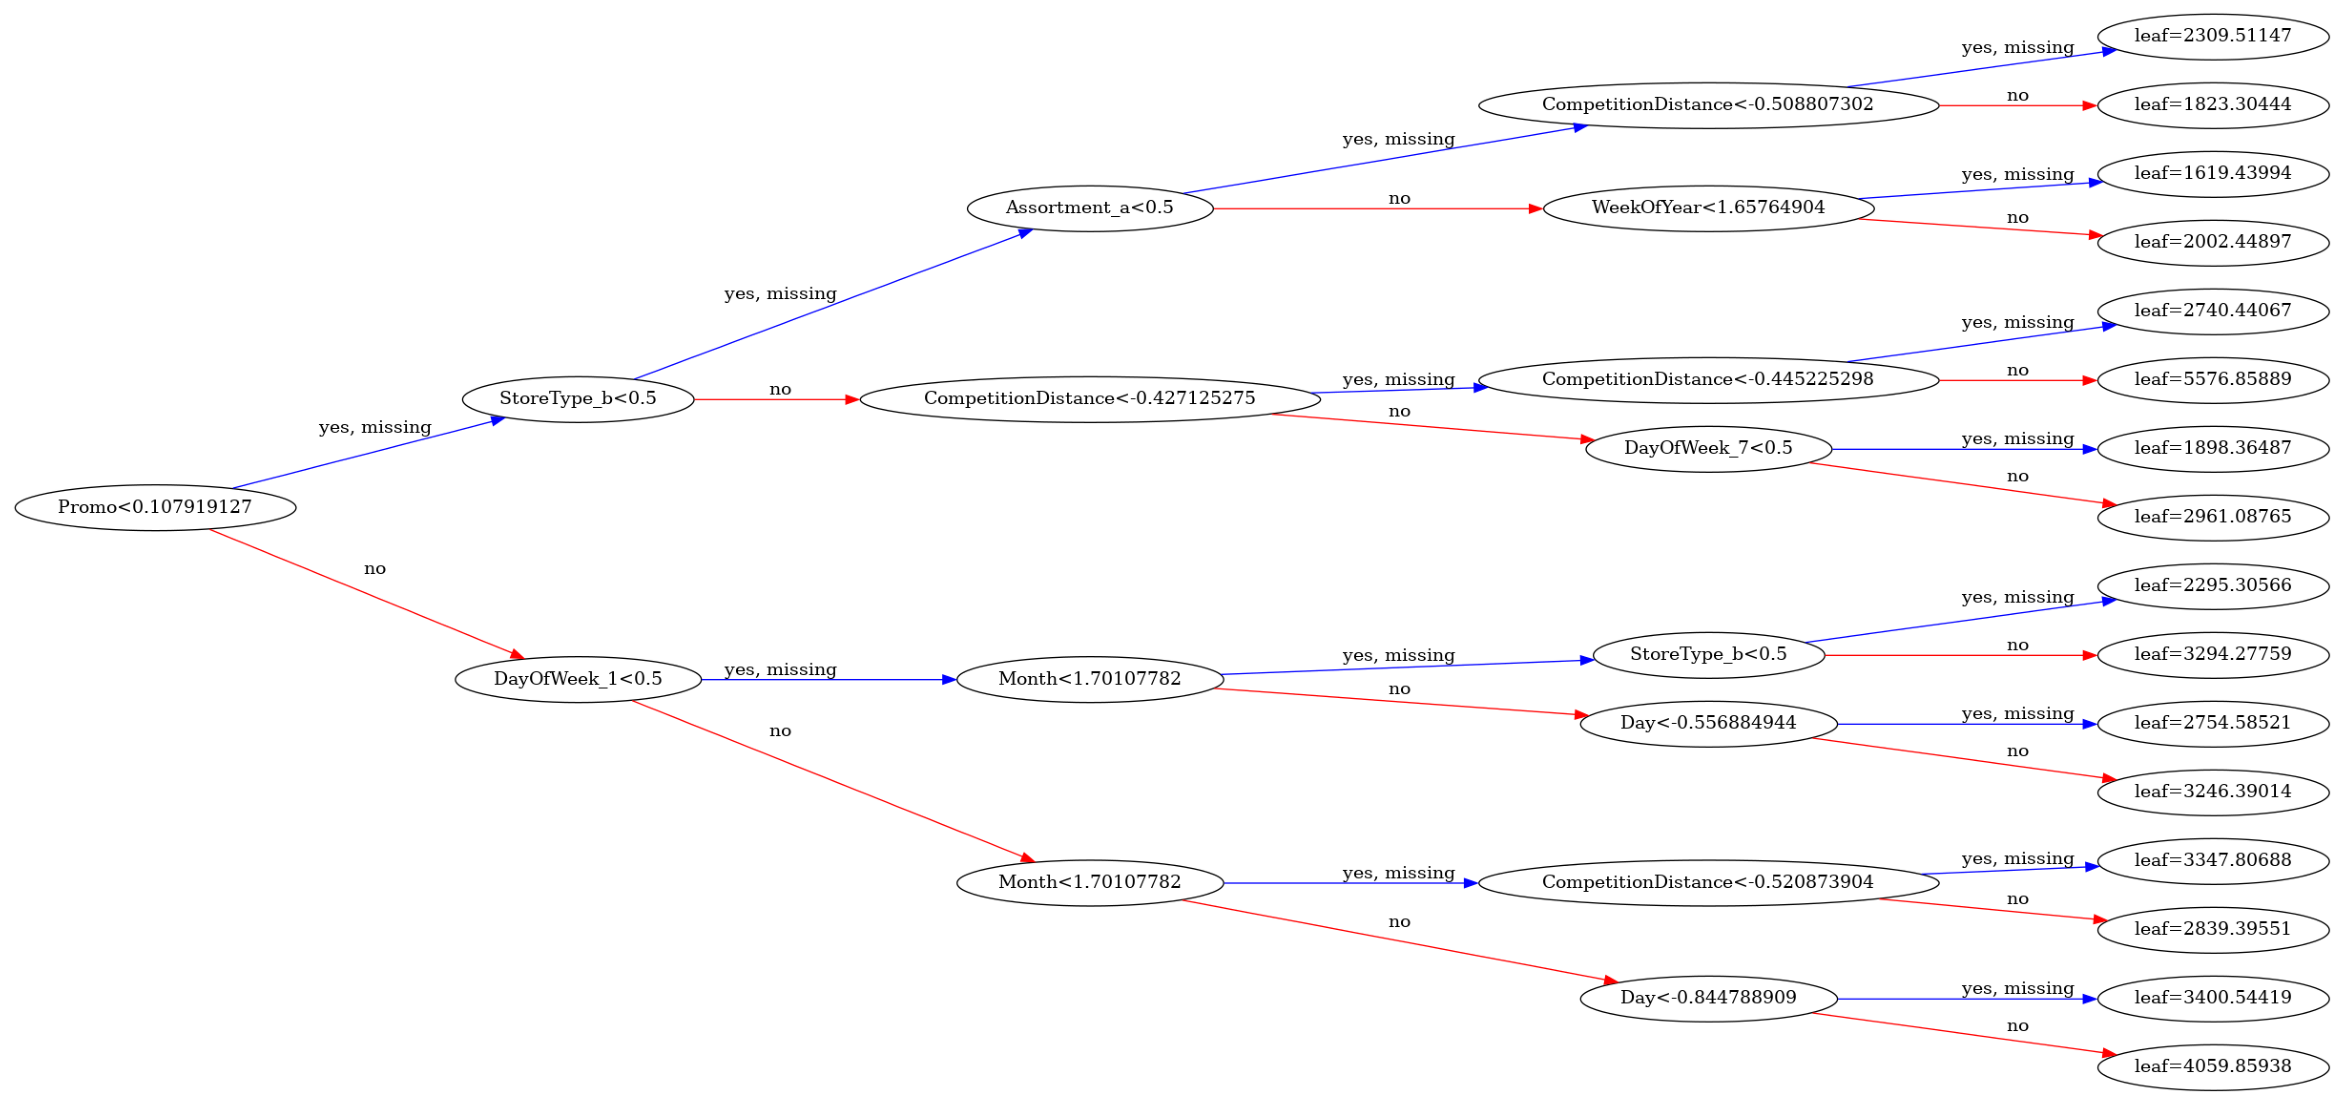

In [70]:
plot_tree(model, rankdir='LR');

The code `plot_tree(model, rankdir='LR')` generates a visual representation of the decision tree produced by an XGBoost model. The `model` parameter is the trained XGBoost regression model.

Decision trees can become very complex, especially when the tree depth is large or there are many features. The graphical representation of the decision tree provides an intuitive way to understand how the model makes predictions by presenting the decisions made at each node in a tree-like structure. 

By specifying the `rankdir` parameter as `'LR'`, the direction of the tree is oriented from left to right, which makes it easier to visualize and interpret for many users.

This plot can be very useful in many ways:
- It helps to understand how the model works by providing a visual representation of the decision-making process.
- It allows us to identify which features are most important in making predictions by examining the splits at each node.
- It can reveal any patterns or relationships that the model has learned from the data.
- It can be used to identify potential overfitting by looking for large trees with many levels.
- It can be used to explain the model's predictions to stakeholders who may not have a background in machine learning. 

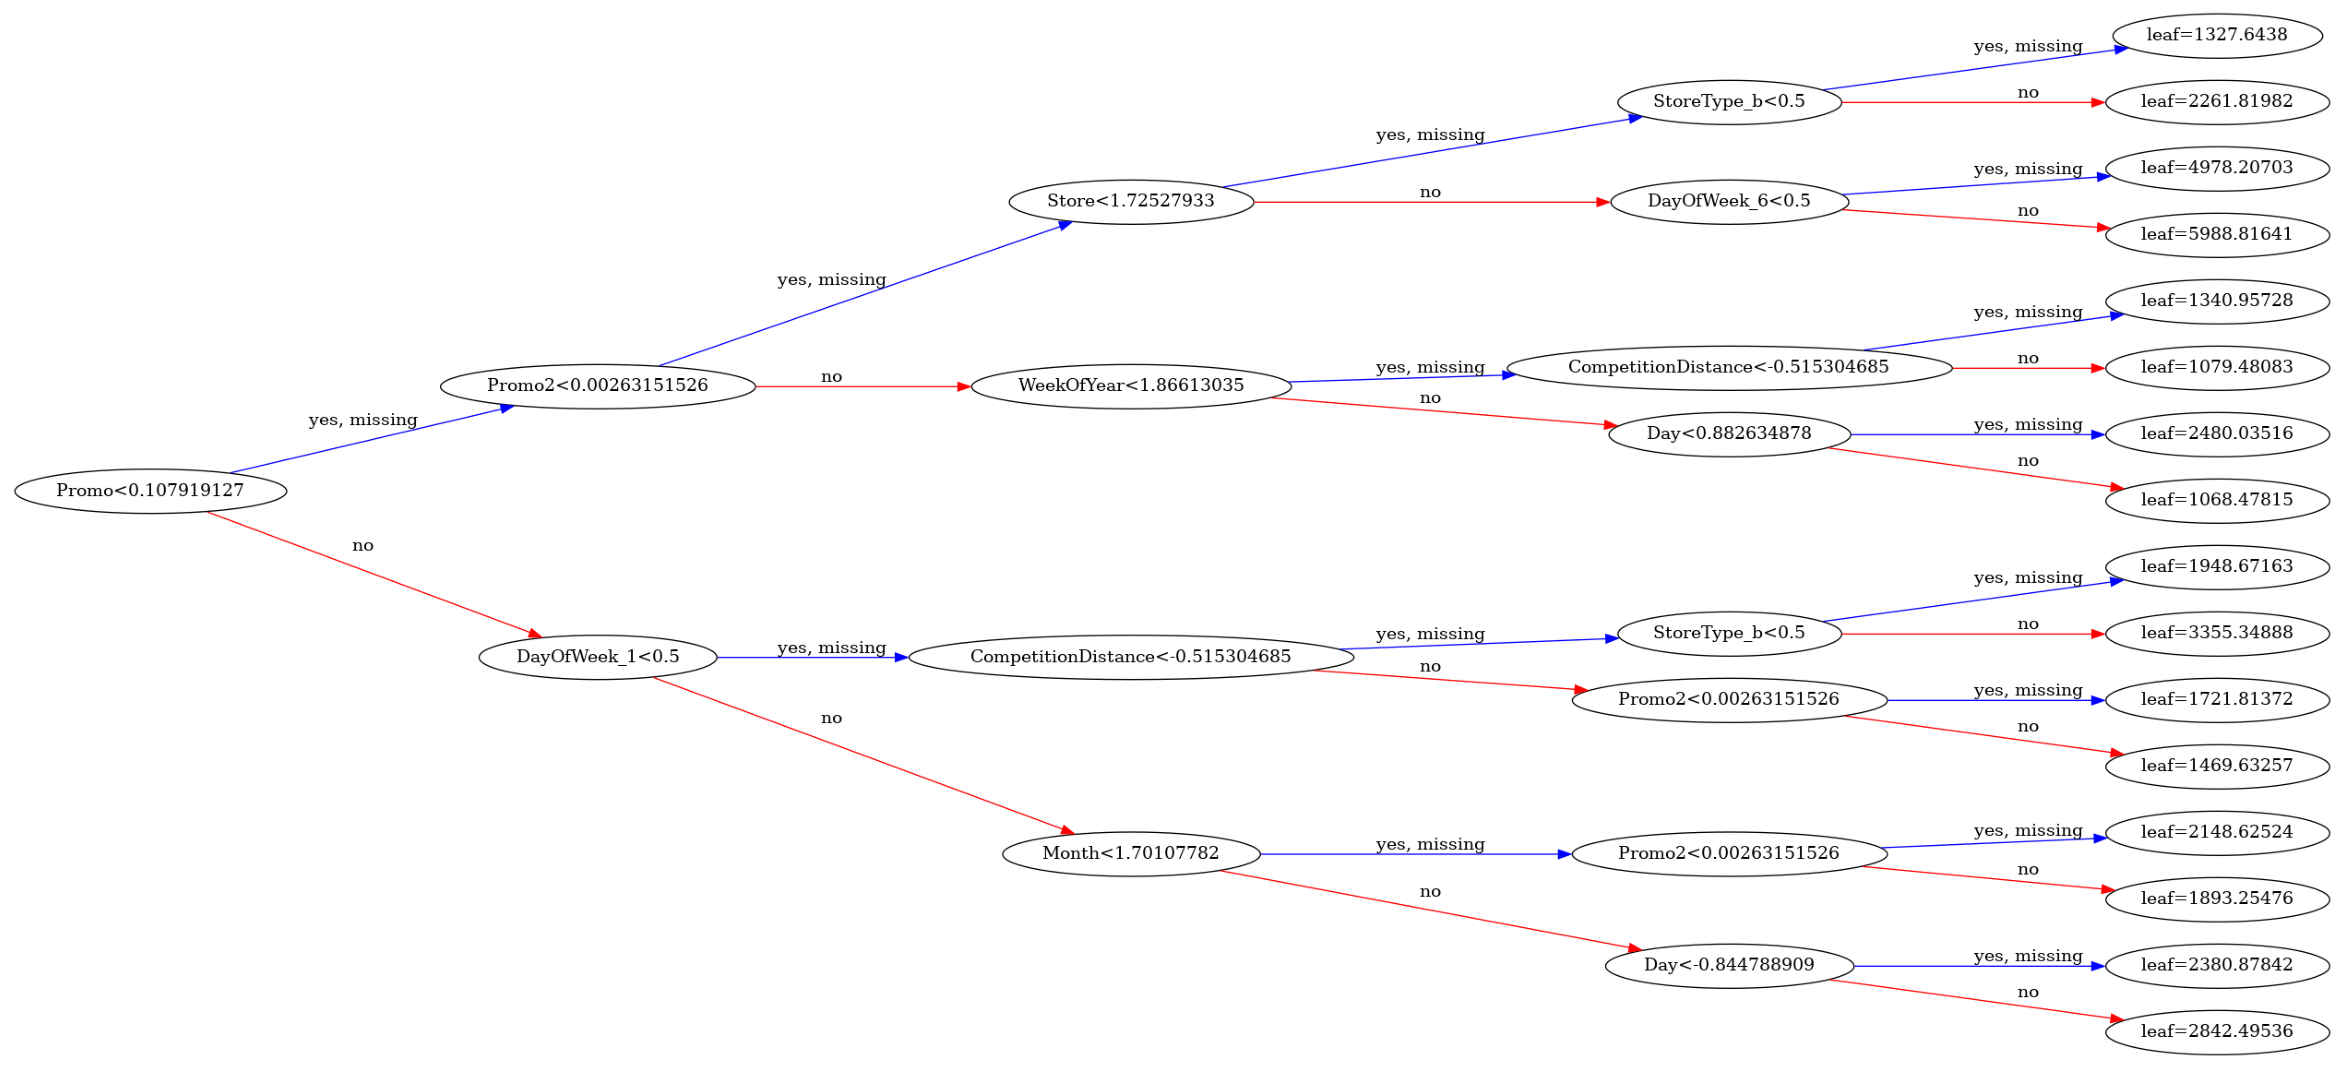

In [71]:
plot_tree(model, rankdir='LR', num_trees=1); #visualization of another tree

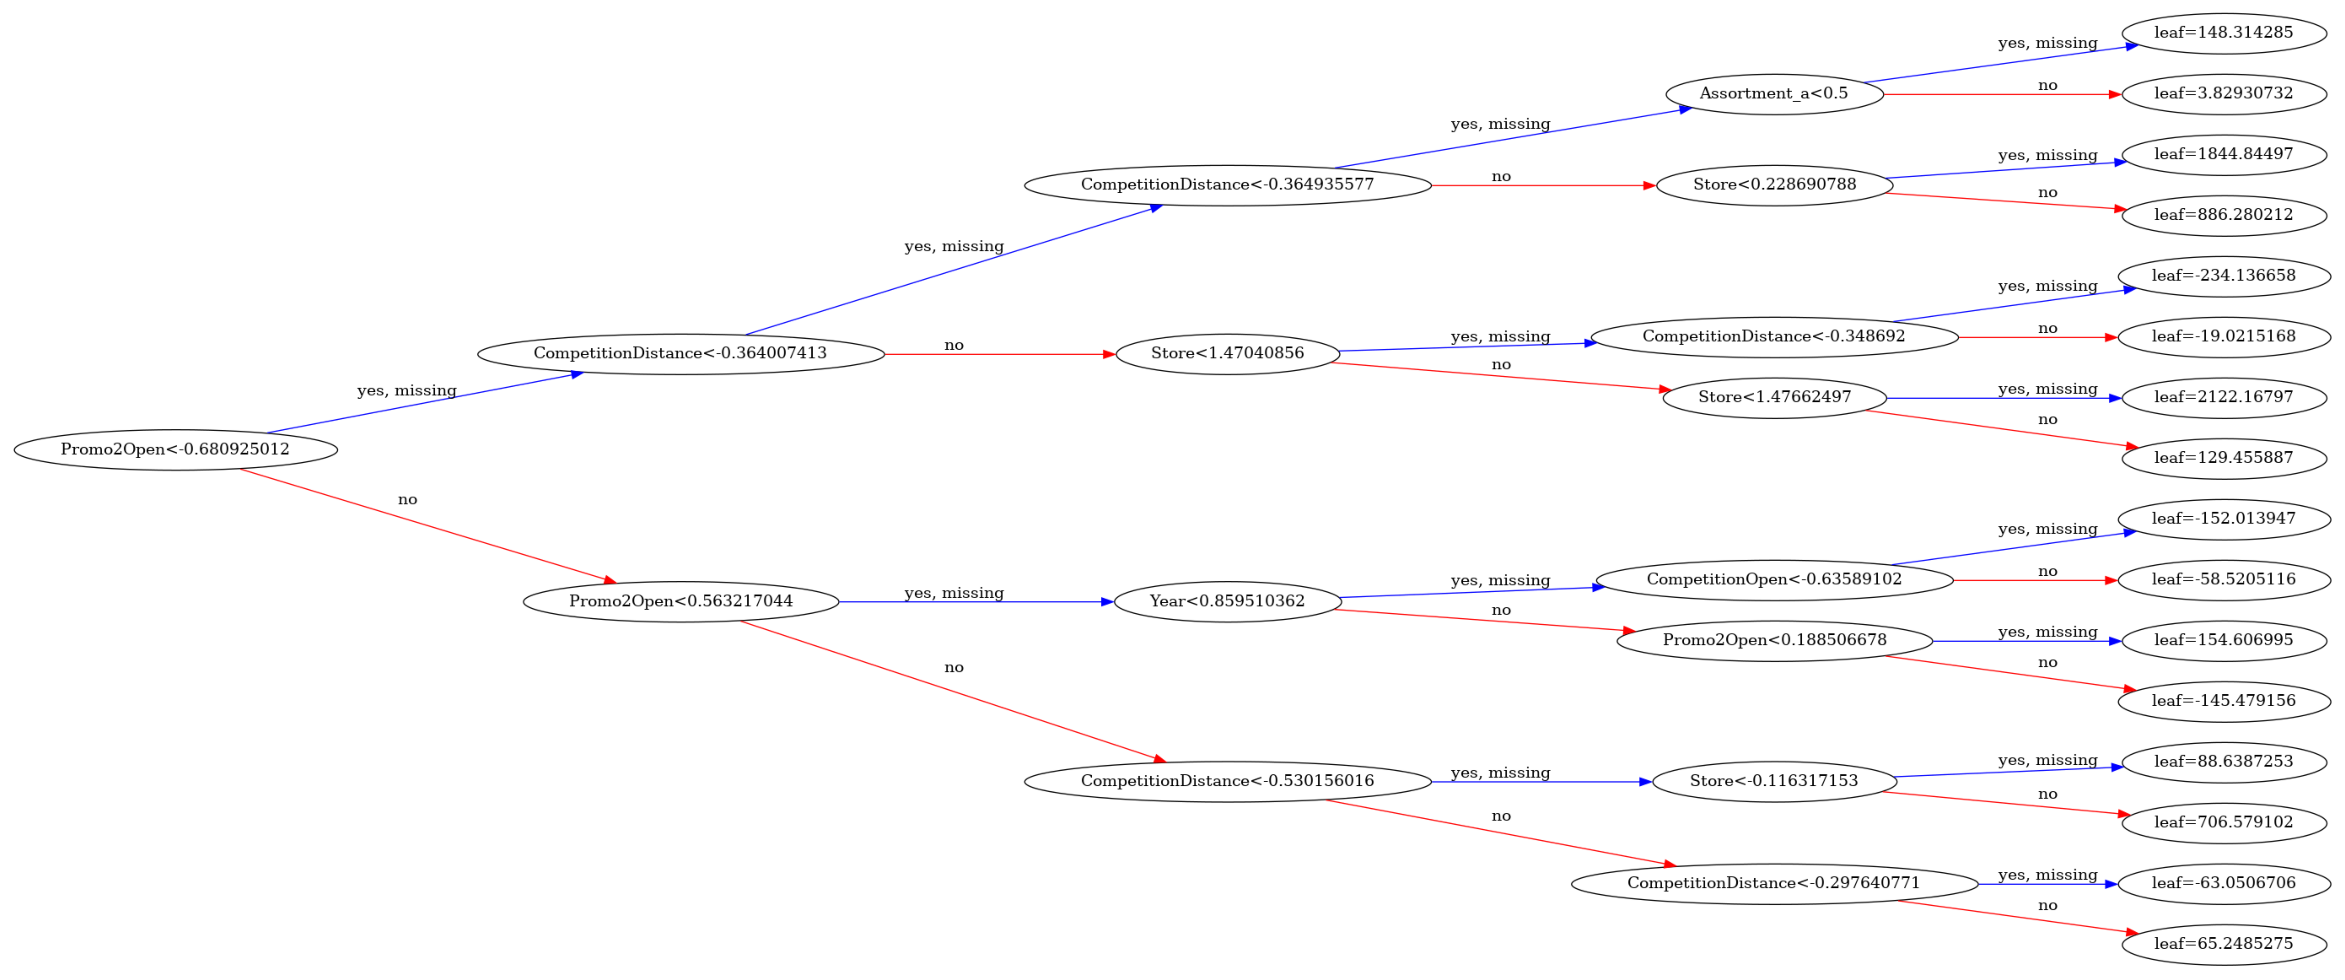

In [72]:
plot_tree(model, rankdir='LR', num_trees=19); #visualization of another tree

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [73]:
trees = model.get_booster().get_dump()

print(trees[0])

0:[Promo<0.107919127] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<-0.508807302] yes=15,no=16,missing=15
				15:leaf=2309.51147
				16:leaf=1823.30444
			8:[WeekOfYear<1.65764904] yes=17,no=18,missing=17
				17:leaf=1619.43994
				18:leaf=2002.44897
		4:[CompetitionDistance<-0.427125275] yes=9,no=10,missing=9
			9:[CompetitionDistance<-0.445225298] yes=19,no=20,missing=19
				19:leaf=2740.44067
				20:leaf=5576.85889
			10:[DayOfWeek_7<0.5] yes=21,no=22,missing=21
				21:leaf=1898.36487
				22:leaf=2961.08765
	2:[DayOfWeek_1<0.5] yes=5,no=6,missing=5
		5:[Month<1.70107782] yes=11,no=12,missing=11
			11:[StoreType_b<0.5] yes=23,no=24,missing=23
				23:leaf=2295.30566
				24:leaf=3294.27759
			12:[Day<-0.556884944] yes=25,no=26,missing=25
				25:leaf=2754.58521
				26:leaf=3246.39014
		6:[Month<1.70107782] yes=13,no=14,missing=13
			13:[CompetitionDistance<-0.520873904] yes=27,no=28,missing=27
				27:

This code retrieves the text representation of all the decision trees in the trained XGBoost model `model`. The `get_booster()` method returns the underlying Booster object of the trained model, and `get_dump()` method returns the text representation of all the trees in the booster. 

Each tree in the returned list is represented as a string with its nodes and leaf values, which can be parsed to obtain the rules used by the model for prediction. This information can be useful for model interpretation and understanding, and can be used to visualize the tree structures and decision paths.

By analyzing the text representation of the trees, we can gain insights into the most important features used by the model, as well as the order and hierarchy of the decision rules. This information can help us identify any biases or inconsistencies in the model, and suggest ways to improve its performance. Additionally, the tree structures can be visualized and shared with non-technical stakeholders for better understanding and communication of the model's predictions.

# Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In machine learning, feature importance refers to the technique of determining which features of the input data are most relevant in predicting the output. In XGBoost, feature importance is calculated as the average gain of splits which use the feature across all trees in the ensemble. This is done by the `feature_importances_` attribute of the XGBoost model.

`model.feature_importances_` returns an array of feature importance scores, where each score corresponds to a specific input feature. The higher the score, the more important that feature is in the model's predictions. The feature importance scores can be used to identify which features have the most predictive power and can be used to create a simplified model with only the most important features, which can lead to faster predictions and improved interpretability.

Overall, `model.feature_importances_` is a useful tool for understanding the relative importance of input features in an XGBoost model and can help with feature selection and model optimization.

In [74]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

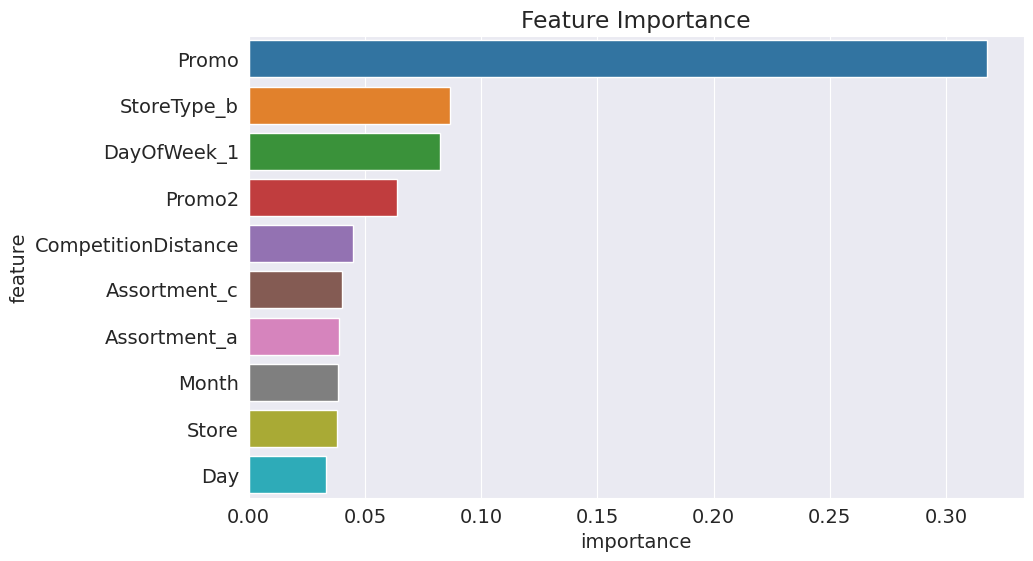

In [82]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

# K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

K-Fold Cross Validation is a popular technique used in machine learning to evaluate the performance of a model. It involves partitioning the dataset into k equally sized folds, where k is typically set to 5 or 10. 

In each of the k iterations, one of the folds is used as the test set, and the other k-1 folds are used as the training set. The model is trained on the training set and then evaluated on the test set. The performance metric, such as accuracy or mean squared error, is then recorded. 

This process is repeated k times, with each fold being used as the test set once. The performance metrics from the k iterations are then averaged to give an overall estimate of the model's performance. This approach helps to reduce the variance of the model by using all of the data for training and testing.

K-Fold Cross Validation is particularly useful when the dataset is small or the model has a high variance. It allows for a more robust estimation of the model's performance and helps to prevent overfitting. By repeating the process k times, the technique also helps to reduce the impact of any random variation in the training and test data.

Scikit-learn provides utilities for performing K fold cross validation. So, we are gonna import necessary libraies.

In [83]:
from sklearn.model_selection import KFold

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

In [85]:
kfold = KFold(n_splits=5)

In [95]:
def train_evaluate_and_predict(X, targets, **params):
    kfold = KFold(n_splits=5)
    models = []
    train_rmses = []
    val_rmses = []

    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model = XGBRegressor(random_state=42, n_jobs=-1, **params)
        model.fit(X_train, train_targets)
        train_rmse = rmse(model.predict(X_train), train_targets)
        val_rmse = rmse(model.predict(X_val), val_targets)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

This function `train_evaluate_and_predict` trains, evaluates, and predicts using an XGBoost regressor model with the given parameters. 

Here's a more detailed explanation of the function:

1. The function takes in three arguments `X`, `targets`, and `**params`. `X` is the input data (features), `targets` are the corresponding target values, and `**params` are the hyperparameters that will be used to train the XGBoost model.

2. The `kfold` variable is initialized with `KFold(n_splits=5)`, which splits the data into five folds for cross-validation.

3. An empty list `models` is initialized to store the XGBoost models trained on each fold.

4. Two empty lists `train_rmses` and `val_rmses` are initialized to store the training and validation root mean squared error (RMSE) for each fold.

5. The `for` loop iterates over the five folds generated by `kfold.split(X)`. In each iteration, the training and validation data are obtained using the indices generated by `train_idxs` and `val_idxs`.

6. A new XGBoost regressor model is created with `XGBRegressor(random_state=42, n_jobs=-1, **params)`, where `random_state=42` sets the random seed for reproducibility and `n_jobs=-1` uses all available CPU cores for parallel computation.

7. The model is trained on the training data using `.fit(X_train, train_targets)`.

8. The training and validation RMSE are calculated using the `rmse()` function and appended to the `train_rmses` and `val_rmses` lists, respectively.

9. The trained XGBoost model is appended to the `models` list.

10. The training and validation RMSE for the current fold are printed to the console.

11. After all five folds have been processed, the function returns the `models`, `train_rmses`, and `val_rmses` lists.

Let's also define a function to average predictions from the 5 different models.

In [ ]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [ ]:
preds = predict_avg(models, X)

In [ ]:
preds

We can now use `predict_avg` to make predictions for the test set.

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
model

In [ ]:
?XGBRegressor

Here's a helper function to test hyperparameters with K-fold cross validation.

In [ ]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [ ]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.


In [ ]:
test_params(n_estimators=10)

In [ ]:
test_params(n_estimators=30)

In [ ]:
test_params(n_estimators=100)

In [ ]:
test_params(n_estimators=240)

> **EXERCISE**: Experiment with different values of `n_estimators`, plot a graph of the training and validation error and determine the best value for `n_estimators`.
> 
> <img src="https://i.imgur.com/EJCrSZw.png" width="360">

#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [ ]:
test_params(max_depth=2)

In [ ]:
test_params(max_depth=5)

In [ ]:
test_params(max_depth=10)

> **EXERCISE**: Experiment with different values of `max_depth`, plot a graph of the training and validation error and determine the optimal.
> 
> <img src="https://i.imgur.com/EJCrSZw.png" width="360">

#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [ ]:
test_params(n_estimators=50, learning_rate=0.01)

In [ ]:
test_params(n_estimators=50, learning_rate=0.1)

In [ ]:
test_params(n_estimators=50, learning_rate=0.3)

In [ ]:
test_params(n_estimators=50, learning_rate=0.9)

In [ ]:
test_params(n_estimators=50, learning_rate=0.99)

> **EXERCISE**: Experiment with different values of `learning_rate`, plot a graph of the training and validation error and determine the optimal.
> 
> <img src="https://i.imgur.com/EJCrSZw.png" width="360">

#### `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [ ]:
test_params(booster='gblinear')

Clearly, a linear model is not well suited for this dataset.

> **EXERCISE**: Exeperiment with other hyperparameters like `gamma`, `min_child_weight`, `max_delta_step`, `subsample`, `colsample_bytree` etc. and find their optimal values. Learn more about them here: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor

> **EXERCISE**: Train a model with your best hyperparmeters and evaluate its peformance using 5-fold cross validation.

Let's save our work before continuing.

In [ ]:
jovian.commit()

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [ ]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [ ]:
%%time
model.fit(X, targets)

Now that the model is trained, we can make predictions on the test set.

In [ ]:
test_preds = model.predict(X_test)

Let's add the predictions into `submission_df`.

In [ ]:
submission_df['Sales']  = test_preds

Recall, however, if if the store is not open, then the sales must be 0. Thus, wherever the value of `Open` in the test set is 0, we can set the sales to 0. Also, there some missing values for `Open` in the test set. We'll replace them with 1 (open).

In [ ]:
test_df.Open.isna().sum()

In [ ]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)

In [ ]:
submission_df

We can now save the predictions as a CSV file.

In [ ]:
submission_df.to_csv('submission.csv', index=None)

In [ ]:
from IPython.display import FileLink

In [ ]:
# Doesn't work on Colab, use the file browser instead.
FileLink('submission.csv')

We can now make a submission on this page and check our score: https://www.kaggle.com/c/rossmann-store-sales/submit

![](https://i.imgur.com/bQ0lpSJ.png)

> **EXERCISE**: Experiment with different models and hyperparameters and try to beat the above score. Take inspiration from the [top notebooks](https://www.kaggle.com/c/rossmann-store-sales/code?competitionId=4594&sortBy=voteCount) on the "Code" tab of the competition.

> **EXERCISE**: Save the model and all the other required objects using `joblib`.

> **EXERCISE**: Write a function `predict_input` which can make predictions for a single input provided as a dictionary. Make sure to include all the feature engineering and preprocessing steps. Refer to previous tutorials for hints.

Let's save our work before continuing.

In [ ]:
jovian.commit()

## Summary and References

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)

The following topics were covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Check out these resources to learn more: 

- https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0
- https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://www.kaggle.com/xwxw2929/rossmann-sales-top1


## Revision Questions
1.	What is a Gradient Boosting Machine (GBM) model?
2.	What does term ‘gradient’ refer to?
3.	What does term ‘boosting’ refer to?
4.	What are weights and bias?
5.	How to choose differentiate/choose numerical and categorical columns?
6.	Why do you scale numerical columns?
7.	Why do you encode categorical columns?
8.	What is rankdir in <code>plot_tree()</code>?
9.	What is the working of K-fold cross validation?
10.	How does gamma hyperparameter work?
11.	What is generalization?
12.	What is ensembling?
13.	What are the different ways to impute missing data?
14.	What are the advantages of XGBoost?
15.	What are the disadvantages of XGBoost?
16.	What are the data pre-processing steps for XGBoost?
17.	What is <code>rcParams</code>?
18.	What does <code>get_dump()</code> do?
19.	What is the difference between XGBoost and LightGBM?
20.	Is XGBoost faster than Random Forest? If so, why?